# <center> POVM as a quantum version of the classifier </center>

In [1]:
import pennylane as qml
from pennylane import numpy as np

from sympy import * 
from sympy.physics.quantum.circuitplot import CircuitPlot,labeller,Mz,CreateOneQubitGate
from sympy.physics.quantum.gate import *
from sympy.physics.quantum.qasm import Qasm

In [2]:
dev = qml.device('default.qubit', wires=2)
dev = qml.device('default.qubit', wires=3)
#dev = qml.device('qiskit.aer', wires=2)
#dev = qml.device('qiskit.ibmq', wires=2, shots=8192, ibmqx_token="e942e97ce86ca8c3609a4053fe6762ec3db17c41895b2d85d6a3560a1156501d57db36753f99138ecb32dca58a97ae5b38005ad39855dd92ab0e86cef852c1a2")

---
## Two-element POVM Module.

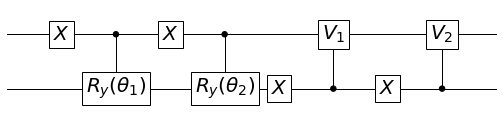

In [3]:
Ry1 = CreateOneQubitGate('Ry1', r'R_y(\theta_1)')
Ry2 = CreateOneQubitGate('Ry2', r'R_y(\theta_2)')
V1 = CreateOneQubitGate('V1', r'V_1')
V2 = CreateOneQubitGate('V2', r'V_2')

CircuitPlot(CGate(0,V2(1))*X(0)*CGate(0,V1(1))*X(0)*CGate(1,Ry2(0))*X(1)*CGate(1,Ry1(0))*X(1),2)

In [4]:
def two_element_povm(params, wires):
    #params 

    # Controlled-RY gate controlled by first qubit in |0> state
    qml.PauliX(wires=wires[0])
    qml.CRY(params[0], wires=[wires[0],wires[1]])
    qml.PauliX(wires=wires[0])
    
    # Controlled-RY gate controlled by first qubit in |1> state
    qml.CRY(params[1], wires=[wires[0],wires[1]])
    
    # Controlled-Rotation gate (arbitrary single-qubit unitary operator) controlled by 2nd qubit in |0> state
    qml.PauliX(wires=wires[1])
    qml.CRot(params[2], params[3], params[4], wires=[wires[1],wires[0]])
    qml.PauliX(wires=wires[1])

    # # Controlled-Rotation gate (arbitrary single-qubit unitary operator) controlled by 2nd qubit in |1> state
    qml.CRot(params[5], params[6], params[7], wires=[wires[1],wires[0]])

#### Test and Drawing `two_element_povm` module

In [5]:
@qml.qnode(dev)
def povm_circuit(params):
    two_element_povm(params, wires=[0, 1])
    return qml.expval(qml.Identity(0) @ qml.PauliZ(1))

# initial parameters
params = np.random.random([8])
povm_circuit(params)

print("Drawing a two-element POVM circuit : ")
print(povm_circuit.draw())

Drawing a two-element POVM circuit : 
 0: ──X──╭C──────────X──╭C─────────────╭Rot(0.758, 0.43, 0.679)─────╭Rot(0.984, 0.202, 0.868)──╭┤ ⟨I ⊗ Z⟩ 
 1: ─────╰RY(0.684)─────╰RY(0.524)──X──╰C────────────────────────X──╰C─────────────────────────╰┤ ⟨I ⊗ Z⟩ 



In [6]:
povm_circuit

<QNode: wires=3, device='default.qubit.autograd', interface='autograd', diff_method='backprop'>

---
## Three-element POVM Module.

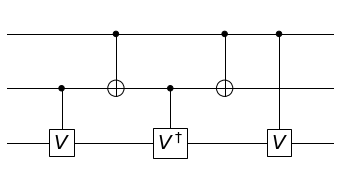

In [7]:
V = CreateOneQubitGate('V', r'V')
Vdg = CreateOneQubitGate('Vdg', r'V^\dagger')
CircuitPlot(CGate(2,V(0))*CNOT(2,1)*CGate((1),Vdg(0))*CNOT(2,1)*CGate((1),V(0)),3)

### Doubly controlled $\hat{R}_y(\theta)$

In [8]:
def CCRY(phi, wires):
    qml.CRY(phi, wires=[wires[1], wires[2]])
    qml.CNOT(wires=[wires[0], wires[1]])
    qml.CRY((-1)*phi, wires=[wires[1], wires[2]])
    qml.CNOT(wires=[wires[0], wires[1]])
    qml.CRY(phi, wires=[wires[0], wires[2]])

In [9]:
@qml.qnode(dev)
def ccry_circuit(params):
    CCRY(params[0], wires=[0, 1, 2])
    return qml.expval(qml.Identity(0) @ qml.PauliZ(1) @ qml.PauliZ(2))

# initial parameters
params = np.random.random([1])
ccry_circuit(params)

print("Drawing a CCRY circuit : ")
print(ccry_circuit.draw())

Drawing a CCRY circuit : 
 0: ──────────────╭C───────────────╭C──╭C──────────╭┤ ⟨I ⊗ Z ⊗ Z⟩ 
 1: ──╭C──────────╰X──╭C───────────╰X──│───────────├┤ ⟨I ⊗ Z ⊗ Z⟩ 
 2: ──╰RY(0.655)──────╰RY(-0.655)──────╰RY(0.655)──╰┤ ⟨I ⊗ Z ⊗ Z⟩ 



### Doubly controlled Rotation $\hat{V}(\phi, \theta, \omega)$

$U(\phi,\theta,\omega)^\dagger = U(-\omega,-\theta,-\gamma)$

In [10]:
def CCRot(phi, theta, omega, wires):
    qml.CRot(phi, theta, omega, wires=[wires[1], wires[2]])
    qml.CNOT(wires=[wires[0], wires[1]])
    qml.CRot((-1)*omega, (-1)*theta, (-1)*phi, wires=[wires[1], wires[2]])
    qml.CNOT(wires=[wires[0], wires[1]])
    qml.CRot(phi, theta, omega, wires=[wires[0], wires[2]])

In [11]:
@qml.qnode(dev)
def ccrot_circuit(params):
    CCRot(params[0], params[1], params[2], wires=[0, 1, 2])
    return qml.expval(qml.Identity(0) @ qml.PauliZ(1) @ qml.PauliZ(2))

# initial parameters
params = np.random.random([3])
ccrot_circuit(params)

print("Drawing a CCRY circuit : ")
print(ccrot_circuit.draw())

Drawing a CCRY circuit : 
 0: ───────────────────────────╭C──────────────────────────────╭C──╭C───────────────────────╭┤ ⟨I ⊗ Z ⊗ Z⟩ 
 1: ──╭C───────────────────────╰X──╭C──────────────────────────╰X──│────────────────────────├┤ ⟨I ⊗ Z ⊗ Z⟩ 
 2: ──╰Rot(0.378, 0.53, 0.25)──────╰Rot(-0.25, -0.53, -0.378)──────╰Rot(0.378, 0.53, 0.25)──╰┤ ⟨I ⊗ Z ⊗ Z⟩ 



### Three-element POVM 

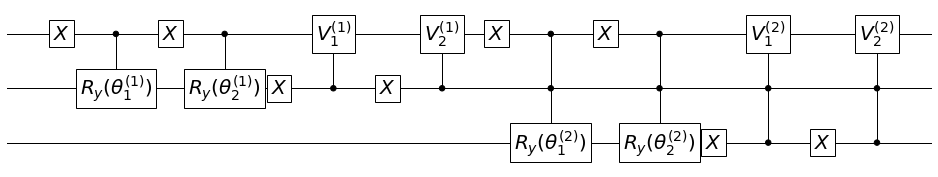

In [12]:
Ry11 = CreateOneQubitGate('Ry1', r'R_y(\theta^{(1)}_1)')
Ry12 = CreateOneQubitGate('Ry2', r'R_y(\theta^{(1)}_2)')
V11 = CreateOneQubitGate('V1', r'V^{(1)}_1')
V12 = CreateOneQubitGate('V2', r'V^{(1)}_2')
Ry21 = CreateOneQubitGate('Ry1', r'R_y(\theta^{(2)}_1)')
Ry22 = CreateOneQubitGate('Ry2', r'R_y(\theta^{(2)}_2)')
V21 = CreateOneQubitGate('V1', r'V^{(2)}_1')
V22 = CreateOneQubitGate('V2', r'V^{(2)}_2')



CircuitPlot(CGate((0,1),V22(2))*X(0)*CGate((0,1),V21(2))*X(0)*CGate((1,2),Ry22(0))*X(2)*CGate((1,2),Ry21(0))*X(2)*CGate(1,V12(2))*X(1)*CGate(1,V11(2))*X(1)*CGate(2,Ry12(1))*X(2)*CGate(2,Ry11(1))*X(2),3)

In [13]:
def three_element_povm(params, wires): 

    two_element_povm(params[:8], wires=[wires[0], wires[1]])

    qml.PauliX(wires=wires[0])
    CCRY(params[8], wires=[wires[0], wires[1], wires[2]])
    qml.PauliX(wires=wires[0])
    CCRY(params[9], wires=[wires[0], wires[1], wires[2]])

    qml.PauliX(wires=wires[2])
    CCRot(params[10], params[11], params[12], wires=[wires[2],wires[1],wires[0]])
    qml.PauliX(wires=wires[2])
    CCRot(params[13], params[14], params[15], wires=[wires[2],wires[1],wires[0]])

In [14]:
@qml.qnode(dev)
def povm_circuit(params):
    three_element_povm(params, wires=[0, 1, 2])
    return qml.expval(qml.Identity(0) @ qml.PauliZ(1) @ qml.PauliZ(2))

# initial parameters
params = np.random.random([16])
povm_circuit(params)

print("Drawing a two-element POVM circuit : ")
print(povm_circuit.draw())

Drawing a two-element POVM circuit : 
 0: ──X──╭C──────────X──╭C─────────────╭Rot(0.547, 0.579, 0.511)─────╭Rot(0.77, 0.765, 0.639)───X──────────╭C───────────────╭C──╭C───────────X──────────╭C───────────────╭C──╭C──────────╭Rot(0.509, 0.6, 0.364)──────╭Rot(-0.364, -0.6, -0.509)──────╭Rot(0.509, 0.6, 0.364)──╭Rot(0.916, 0.172, 0.743)──────╭Rot(-0.743, -0.172, -0.916)──────╭Rot(0.916, 0.172, 0.743)──╭┤ ⟨I ⊗ Z ⊗ Z⟩ 
 1: ─────╰RY(0.225)─────╰RY(0.984)──X──╰C─────────────────────────X──╰C────────────────────────╭C──────────╰X──╭C───────────╰X──│───────────╭C──────────╰X──╭C───────────╰X──│───────────╰C───────────────────────╭X──╰C──────────────────────────╭X──│────────────────────────╰C─────────────────────────╭X──╰C────────────────────────────╭X──│──────────────────────────├┤ ⟨I ⊗ Z ⊗ Z⟩ 
 2: ───────────────────────────────────────────────────────────────────────────────────────────╰RY(0.743)──────╰RY(-0.743)──────╰RY(0.743)──╰RY(0.368)──────╰RY(-0.368)──────╰RY(0.368)───X─────────────────

---
## Preparing arbitrary pure states in the quantum circuit

In [15]:
#@qml.qnode(dev)
def state_preparation(statevector, wire):
    theta = 2 * np.arccos(statevector[0])
    phi = np.angle(statevector[1]/np.sin(theta/2)) if not np.isclose(np.sin(theta/2), 0) else 0
    #print(theta, phi)

    qml.Rot(phi, theta, (-1)*phi, wires=wire)
    #return qml.state()

Examples <br>
$n=2$ <br>
$n=3$, $|\psi_0\rangle = |0\rangle$, $|\psi_1\rangle = (|0\rangle + \sqrt{3} |1\rangle)/2$, $|\psi_2\rangle = (|0\rangle - \sqrt{3} |1\rangle)/2$

---
## Minimum Error Discrimination

Preparation: $\{q_i,\hat{\rho}_i\}^{N}_{i=1}$ $\longleftarrow$ $\hat{\rho} = \sum_i q_i\hat{\rho}_i$. <br>

POVMs: $\{E_k\}_{k=1}^{L}$ with $\sum_{k=1}^{L} E_k = I$.

For three-element POVMs $\{\hat{E}_0, \hat{E}_1, \hat{E}_2\}$ on three different state prepared as $\{(q_0,\hat{\rho}_0), (q_1,\hat{\rho}_1), (q_2,\hat{\rho}_2)\}$, 
$$
p_{error} = 1 - p_{guess} = 1-\max_{\vec{\theta}}\left(q_0\text{Tr}[\hat{E}_0\hat{\rho}_0] + q_1\text{Tr}[\hat{E}_1\hat{\rho}_1] + q_2\text{Tr}[\hat{E}_2\hat{\rho}_2]\right)
$$

---
## Probabilities

$$
p(k) = \langle \psi_k|\hat{K}^\dagger_k\hat{K}_k|\psi_k\rangle = \text{Tr}[\hat{E}_k\hat{\rho}_k]
$$

In [16]:
@qml.qnode(dev)
def circuit_povm_probs(init_state, params):
    state_preparation(init_state, wire=0)

    # arbitrary rotation
    qml.Rot(params[0], params[1], params[2], wires=0)

    # two-element POVM
    three_element_povm(params[3:], wires=[0, 1, 2])

    #qml.CNOT(wires=[2,1])

    return qml.probs(wires=[1, 2])

---

Optimal POVM for State Discrimination

In [17]:
def cost(x):
    psi0 = [1, 0]
    psi1 = [1/2, np.sqrt(3)/2]
    psi2 = [1/2, (-1)*np.sqrt(3)/2]

    prob0 = circuit_povm_probs(psi0, x)[0]
    prob1 = circuit_povm_probs(psi1, x)[2]
    prob2 = circuit_povm_probs(psi2, x)[3]

    q0 = 1/2
    q1 = 1/2
    q2 = 1/2

    res = 1 - (q0 * prob0 + q1 * prob1 + q2 * prob2)
    return res


In [32]:
# initialise the optimizer
opt = qml.GradientDescentOptimizer(stepsize=0.4)

# set the number of steps
steps = 200

# set the initial parameter values
params = 4 * np.pi * np.random.random([19])
print("cost(init_params) =", cost(params))

for i in range(steps):
    # update the circuit parameters
    params = opt.step(cost, params)

    if (i+1) % 5 == 0:
        print("Cost after step {:5d}: {: .7f}".format(i + 1, cost(params)))

print("Optimized rotation angles: {}".format(params))

cost(init_params) = 0.44632437676803105
Cost after step     5:  0.1931916
Cost after step    10:  0.0703299
Cost after step    15:  0.0338388
Cost after step    20:  0.0204800
Cost after step    25:  0.0129653
Cost after step    30:  0.0082205
Cost after step    35:  0.0051899
Cost after step    40:  0.0032641
Cost after step    45:  0.0020476
Cost after step    50:  0.0012824
Cost after step    55:  0.0008025
Cost after step    60:  0.0005019
Cost after step    65:  0.0003139
Cost after step    70:  0.0001964
Cost after step    75:  0.0001228
Cost after step    80:  0.0000769
Cost after step    85:  0.0000481
Cost after step    90:  0.0000301
Cost after step    95:  0.0000189
Cost after step   100:  0.0000118
Cost after step   105:  0.0000074
Cost after step   110:  0.0000046
Cost after step   115:  0.0000029
Cost after step   120:  0.0000018
Cost after step   125:  0.0000011
Cost after step   130:  0.0000007
Cost after step   135:  0.0000005
Cost after step   140:  0.0000003
Cost aft

---

In [33]:
def unitaries_in_povm(params):
    U = qml.Rot(params[0], params[1], params[2], wires=2).matrix
    Ry00 = qml.RY(params[3], wires=2).matrix
    Ry01 = qml.RY(params[4], wires=2).matrix
    V00 = qml.Rot(params[5], params[6], params[7], wires=2).matrix
    V01 = qml.Rot(params[8], params[9], params[10], wires=2).matrix
    Ry10 = qml.RY(params[11], wires=2).matrix
    Ry11 = qml.RY(params[12], wires=2).matrix
    V10 = qml.Rot(params[13], params[14], params[15], wires=2).matrix
    V11 = qml.Rot(params[16], params[17], params[18], wires=2).matrix


    return U, Ry00, Ry01, V00, V01, Ry10, Ry11, V10, V11

U, Ry00, Ry01, V00, V01, Ry10, Ry11, V10, V11 = unitaries_in_povm(params)

$$
\hat{K}_0 = V^{(0)}_0D^{(0)}_0U \\
\hat{K}_1 = V^{(1)}_0D^{(1)}_0V^{(0)}_1D^{(0)}_1U \\
\hat{K}_2 = V^{(1)}_1D^{(1)}_1V^{(0)}_1D^{(0)}_1U 
$$

In [34]:
def kraus_op(params):
    U, _, _, V00, V01, _, _, V10, V11 = unitaries_in_povm(params)
    D00 = np.diag([np.cos(params[3]/2), np.cos(params[4]/2)])
    D01 = np.diag([np.sin(params[3]/2), np.sin(params[4]/2)])
    D10 = np.diag([np.cos(params[11]/2), np.cos(params[12]/2)])
    D11 = np.diag([np.sin(params[11]/2), np.sin(params[12]/2)])
    K0 = np.dot(np.dot(V00, D00), U)
    _mid = np.dot(np.dot(V01, D01), U)
    K1 = np.dot(np.dot(V10,D10),_mid)
    K2 = np.dot(np.dot(V11,D11),_mid)
    

    return K0, K1, K2

In [35]:
K0, K1, K2 = kraus_op(params)

print("K0 =", K0)
print("K1 =", K1)
print("K2 =", K2)

K0 = [[-3.73478769e-01-3.48697028e-01j  2.07674116e-05-3.15678344e-06j]
 [ 6.12029819e-01+1.76060141e-01j -2.12804154e-05+1.52516026e-05j]]
K1 = [[ 0.09442395-0.06028055j -0.16353987+0.10439581j]
 [-0.06808869+0.2572012j   0.11794167-0.44545095j]]
K2 = [[-0.02980864-0.47080745j  0.1358702 -0.49495669j]
 [ 0.09376274+0.13663274j  0.10282349-0.68993038j]]


In [36]:
E0 = np.dot(K0.conj().T, K0) 
E1 = np.dot(K1.conj().T, K1)
E2 = np.dot(K2.conj().T, K2)
print("E0 =", E0)
print("E1 =", E1)
print("E2 =", E2)
print("E0 + E1 + E2 =", E0 + E1 + E2)

E0 = [[ 6.66653681e-01+0.00000000e+00j -1.69944758e-05+2.15015948e-05j]
 [-1.69944758e-05-2.15015948e-05j  1.12671813e-09+0.00000000e+00j]]
E1 = [[ 0.08333816+0.00000000e+00j -0.14433613-5.37513954e-06j]
 [-0.14433613+5.37513954e-06j  0.24998056+0.00000000e+00j]]
E2 = [[0.25000816+0.00000000e+00j 0.14435312-1.61264553e-05j]
 [0.14435312+1.61264553e-05j 0.75001944+0.00000000e+00j]]
E0 + E1 + E2 = [[1.00000000e+00+0.00000000e+00j 8.32667268e-17+1.83026879e-17j]
 [8.32667268e-17-1.83026879e-17j 1.00000000e+00+0.00000000e+00j]]


In PRA,

In [37]:
M2 = (1/np.sqrt(6)) * np.array([[1/4, np.sqrt(3)/4],[np.sqrt(3)/4, 3/4]])
M3 = (1/np.sqrt(6)) * np.array([[1/4, -np.sqrt(3)/4],[-np.sqrt(3)/4, 3/4]])

In [38]:
print(np.dot(M2.T, M2))
print(np.dot(M3.T, M3))

[[0.04166667 0.07216878]
 [0.07216878 0.125     ]]
[[ 0.04166667 -0.07216878]
 [-0.07216878  0.125     ]]


In [39]:
res = np.dot(K0, np.array([1,0]))
np.dot(res.conj(),res)

(0.6666536805367365+0j)

In [40]:
res = np.dot(K1, np.array([1/2,np.sqrt(3)/2]))
np.dot(res.conj(),res)

(0.08332120134780044+0j)

In [41]:
res = np.dot(K2, np.array([1/2,(-1)*np.sqrt(3)/2]))
np.dot(res.conj(),res)

(0.5000031497040741+0j)